03:26 bilby INFO    : Running for label 'sinusoidal_fit_test', output will be saved to 'outdir'
03:26 bilby INFO    : Analysis priors:
03:26 bilby INFO    : amplitude=Uniform(minimum=0, maximum=3, name='amplitude', latex_label='amplitude', unit=None, boundary=None)
03:26 bilby INFO    : frequency=Uniform(minimum=0.1, maximum=0.5, name='frequency', latex_label='frequency', unit=None, boundary=None)
03:26 bilby INFO    : phase=Uniform(minimum=0, maximum=6.283185307179586, name='phase', latex_label='$\\phi$', unit=None, boundary=None)
03:26 bilby INFO    : offset=Uniform(minimum=-2, maximum=2, name='offset', latex_label='offset', unit=None, boundary=None)
03:26 bilby INFO    : sigma=Uniform(minimum=0, maximum=1, name='sigma', latex_label='sigma', unit=None, boundary=None)
03:26 bilby INFO    : Analysis likelihood class: <class 'bilby.core.likelihood.GaussianLikelihood'>
03:26 bilby INFO    : Analysis likelihood noise evidence: nan
03:26 bilby INFO    : Single likelihood evaluation took 1.

1it [00:00, ?it/s]

03:28 bilby INFO    : Written checkpoint file outdir/sinusoidal_fit_test_resume.pickle
03:28 bilby INFO    : Rejection sampling nested samples to obtain 2008 posterior samples
03:28 bilby INFO    : Sampling time: 0:02:04.282500


03:28 bilby INFO    : Summary of results:
nsamples: 2008
ln_noise_evidence:    nan
ln_evidence: 10.849 +/-  0.253
ln_bayes_factor:    nan +/-  0.253



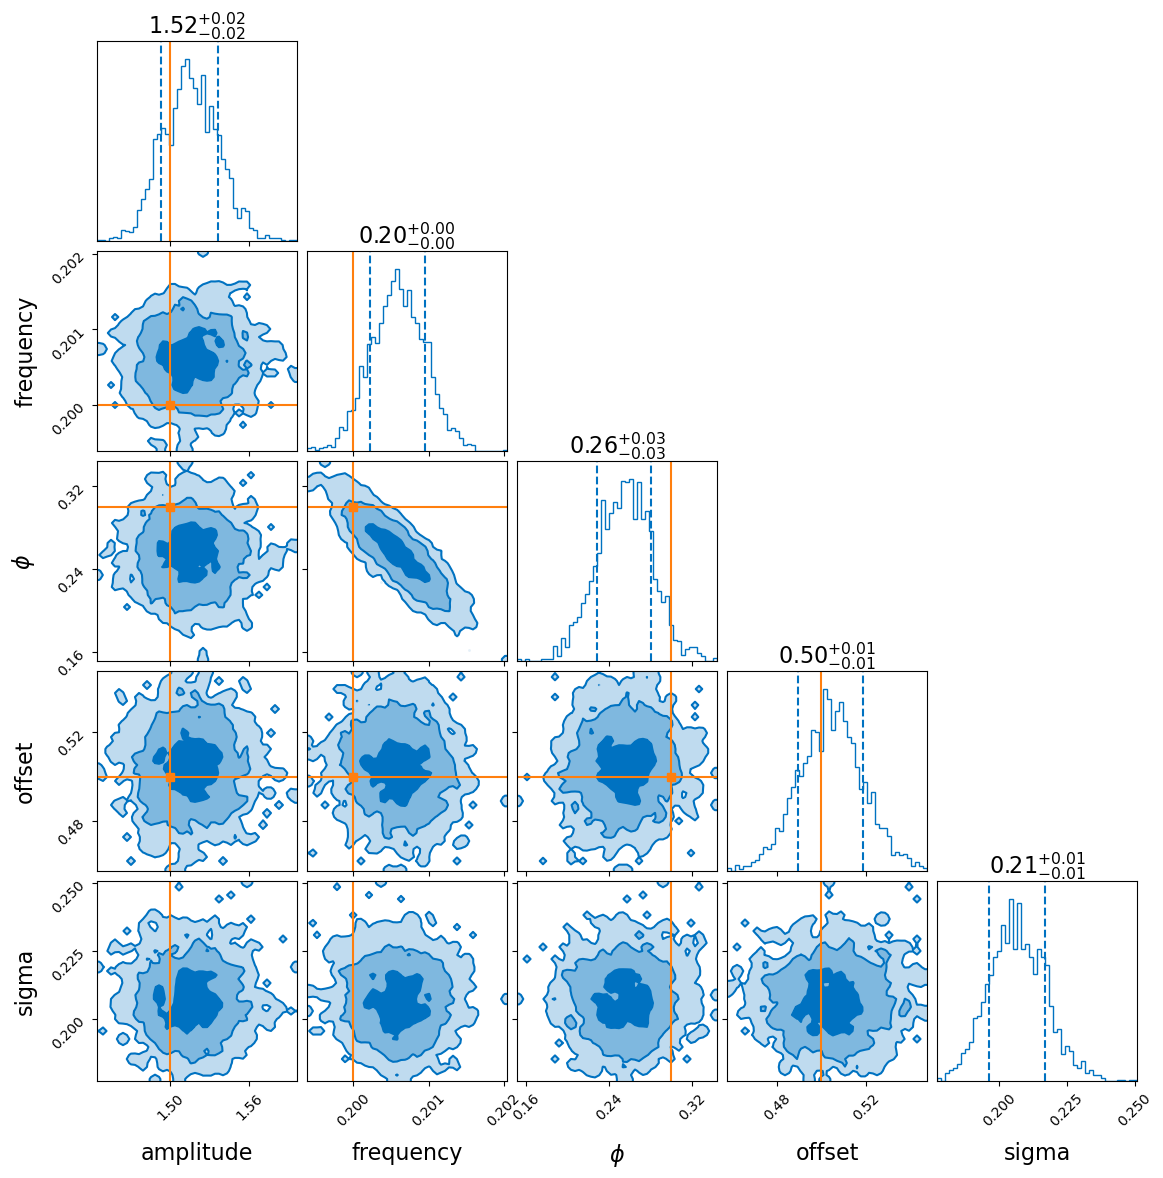

In [2]:
import bilby
import matplotlib.pyplot as plt
import numpy as np

# just setup stuff
label = "sinusoidal_fit_test"
outdir = "outdir"  
bilby.utils.check_directory_exists_and_if_not_mkdir(outdir) #i recently found out sometimes i dont need to make the outdir actually 

# the wave maker function
def sine_model(time, amplitude, frequency, phase, offset):
    """makes wavy stuff: size*sin(speed*time + shift) + move up/down"""
    return amplitude * np.sin(2*np.pi*frequency*time + phase) + offset

# the true numbers we pretend we dont know
injection_parameters = dict(
    amplitude=1.5,    # how tall the waves are
    frequency=0.2,    # how many waves crammed together
    phase=0.3,        # side shuffle of the waves
    offset=0.5        # up/down push of everything
)
sigma = 0.2  # how messy we make the data (reduced from 1 in the example)

# making fake data to play with
time_duration = 20    # just to show more cycles
sampling_frequency = 10  
time = np.linspace(0, time_duration, int(time_duration*sampling_frequency))  
data = sine_model(time, **injection_parameters) + np.random.normal(0, sigma, len(time)) # adding noise

# quick look at our fake data
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(time, data, "o", label="our messy data", alpha=0.7)
ax.plot(time, sine_model(time, **injection_parameters), "--r", label="real wave")
ax.set_xlabel("time")
ax.set_ylabel("wavyness")
ax.legend()
ax.grid(True)
fig.savefig(f"{outdir}/{label}_data.png") # saving for later

# how bilby knows good vs bad fits (same as example but with our wave model)
likelihood = bilby.core.likelihood.GaussianLikelihood(time, data, sine_model)

# our guesses about possible numbers
priors = dict(
    amplitude=bilby.core.prior.Uniform(0, 3, "amplitude"), # waves cant be negative
    frequency=bilby.core.prior.Uniform(0.1, 0.5, "frequency"), # not too fast/slow
    phase=bilby.core.prior.Uniform(0, 2*np.pi, "phase"), # full circle of options
    offset=bilby.core.prior.Uniform(-2, 2, "offset"), # could be above/below zero
    sigma=bilby.core.prior.Uniform(0, 1, "sigma") # noise cant be negative (smaller range since we used sigma=0.2)
)

# let bilby do its thing
result = bilby.run_sampler(
    likelihood=likelihood,
    priors=priors,
    sampler="dynesty", # the math magic
    npoints=500, # more tries than example's 250 since we have more parameters
    injection_parameters=injection_parameters, # our secret true numbers
    outdir=outdir,
    label=label,
)


result.plot_corner()